In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1
time: 8.38 s (started: 2023-05-08 13:44:00 +00:00)


In [4]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.38 s (started: 2023-05-08 13:44:08 +00:00)


In [ ]:
#unzip the data that we had split earlier before in the preprocessing notebook, to ensure that the same arrangement of data 
#is used for every model. 
!unzip /isic2019-dataset.zip

In [9]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters
resize_size = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the randaugment transformation pipeline for the training set
randaug_transform = Compose([
    Resize(resize_size, interpolation=interpolation),
    transforms.CenterCrop(size=224),
    RandAugment(num_ops=3, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

#define the transformation function for the validation and test set
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


time: 2.9 ms (started: 2023-05-07 14:24:25 +00:00)


In [11]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn.metrics import f1_score

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparamete optimization code 

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5, pin_memory=True)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'maxvit_rmlp_small_rw_224'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)

    num_in_features = model.get_classifier().in_features

    # Define the classification head with the number of neurons and hidden layers to optimize 
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    num_epochs = 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    best_f1_score = 0.0
    patience = 3
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader.dataset)

        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the accuracy, validation loss, and f1-score
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%, F1-score = {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_f1_score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-07 14:25:00,519] A new study created in memory with name: no-name-c62b124e-6bae-466f-b159-7cc6223f3618


Epoch 1: Train Loss = 1.2097, Train Accuracy = 59.82%, Validation Loss = 0.9838, Validation Accuracy = 66.38%, F1-score = 0.3514
Epoch 2: Train Loss = 0.9645, Train Accuracy = 65.45%, Validation Loss = 0.8887, Validation Accuracy = 68.46%, F1-score = 0.4242
Epoch 3: Train Loss = 0.9230, Train Accuracy = 66.96%, Validation Loss = 0.8854, Validation Accuracy = 68.30%, F1-score = 0.3796
Epoch 4: Train Loss = 0.9206, Train Accuracy = 67.09%, Validation Loss = 0.8606, Validation Accuracy = 69.05%, F1-score = 0.3733
Epoch 5: Train Loss = 0.9138, Train Accuracy = 67.03%, Validation Loss = 0.8651, Validation Accuracy = 68.77%, F1-score = 0.3923
Epoch 6: Train Loss = 0.9231, Train Accuracy = 66.85%, Validation Loss = 0.8721, Validation Accuracy = 68.22%, F1-score = 0.3921


[I 2023-05-07 14:38:30,933] Trial 0 finished with value: 0.4241945784172435 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0069114311730783164, 'learning_rate': 0.008103652818888335, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 0 with value: 0.4241945784172435.


Epoch 7: Train Loss = 0.9181, Train Accuracy = 67.18%, Validation Loss = 0.8783, Validation Accuracy = 69.17%, F1-score = 0.3879
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2360, Train Accuracy = 58.60%, Validation Loss = 0.9508, Validation Accuracy = 66.46%, F1-score = 0.4057
Epoch 2: Train Loss = 0.9703, Train Accuracy = 65.14%, Validation Loss = 0.9299, Validation Accuracy = 66.93%, F1-score = 0.4032
Epoch 3: Train Loss = 0.9270, Train Accuracy = 66.41%, Validation Loss = 0.8606, Validation Accuracy = 68.38%, F1-score = 0.4425
Epoch 4: Train Loss = 0.9164, Train Accuracy = 66.86%, Validation Loss = 0.8442, Validation Accuracy = 70.07%, F1-score = 0.4592
Epoch 5: Train Loss = 0.9117, Train Accuracy = 67.00%, Validation Loss = 0.8454, Validation Accuracy = 69.25%, F1-score = 0.4658
Epoch 6: Train Loss = 0.8973, Train Accuracy = 67.70%, Validation Loss = 0.8315, Validation Accuracy = 69.87%, F1-score = 0.4581
Epoch 7: Train Loss = 0.8937, Train Accuracy 

[I 2023-05-07 15:00:44,316] Trial 1 finished with value: 0.4919851999085236 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.001632089885616201, 'learning_rate': 0.005261751128460169, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 1 with value: 0.4919851999085236.


Epoch 12: Train Loss = 0.8677, Train Accuracy = 68.57%, Validation Loss = 0.8266, Validation Accuracy = 70.03%, F1-score = 0.4818
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1761, Train Accuracy = 61.11%, Validation Loss = 0.9145, Validation Accuracy = 68.07%, F1-score = 0.3838
Epoch 2: Train Loss = 0.9468, Train Accuracy = 66.01%, Validation Loss = 0.8625, Validation Accuracy = 68.70%, F1-score = 0.4353
Epoch 3: Train Loss = 0.9077, Train Accuracy = 67.02%, Validation Loss = 0.8523, Validation Accuracy = 68.38%, F1-score = 0.4431
Epoch 4: Train Loss = 0.8911, Train Accuracy = 67.91%, Validation Loss = 0.8366, Validation Accuracy = 70.23%, F1-score = 0.4648
Epoch 5: Train Loss = 0.8863, Train Accuracy = 67.88%, Validation Loss = 0.8308, Validation Accuracy = 70.46%, F1-score = 0.4936
Epoch 6: Train Loss = 0.8776, Train Accuracy = 68.17%, Validation Loss = 0.8349, Validation Accuracy = 69.87%, F1-score = 0.4814
Epoch 7: Train Loss = 0.8661, Train Accuracy

[I 2023-05-07 15:21:14,592] Trial 2 finished with value: 0.5080757268280853 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.003731446865245378, 'learning_rate': 0.003313862120379829, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.5080757268280853.


Epoch 11: Train Loss = 0.8628, Train Accuracy = 68.71%, Validation Loss = 0.8285, Validation Accuracy = 70.46%, F1-score = 0.4819
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2544, Train Accuracy = 58.21%, Validation Loss = 0.9593, Validation Accuracy = 65.44%, F1-score = 0.3554
Epoch 2: Train Loss = 0.9705, Train Accuracy = 65.08%, Validation Loss = 0.9321, Validation Accuracy = 67.40%, F1-score = 0.4313
Epoch 3: Train Loss = 0.9252, Train Accuracy = 66.87%, Validation Loss = 0.8920, Validation Accuracy = 67.32%, F1-score = 0.3808
Epoch 4: Train Loss = 0.9165, Train Accuracy = 67.03%, Validation Loss = 0.8676, Validation Accuracy = 68.66%, F1-score = 0.4510
Epoch 5: Train Loss = 0.9129, Train Accuracy = 67.09%, Validation Loss = 0.8613, Validation Accuracy = 68.62%, F1-score = 0.4685
Epoch 6: Train Loss = 0.9137, Train Accuracy = 67.23%, Validation Loss = 0.8458, Validation Accuracy = 69.13%, F1-score = 0.4074
Epoch 7: Train Loss = 0.9043, Train Accuracy

[I 2023-05-07 15:41:24,235] Trial 3 finished with value: 0.5212314456692965 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0014930361438452162, 'learning_rate': 0.006691203124364596, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 3 with value: 0.5212314456692965.


Epoch 12: Train Loss = 0.8817, Train Accuracy = 67.98%, Validation Loss = 0.8418, Validation Accuracy = 71.13%, F1-score = 0.5212
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1968, Train Accuracy = 60.08%, Validation Loss = 0.9316, Validation Accuracy = 66.93%, F1-score = 0.3097
Epoch 2: Train Loss = 0.9541, Train Accuracy = 66.08%, Validation Loss = 0.8600, Validation Accuracy = 69.13%, F1-score = 0.4233
Epoch 3: Train Loss = 0.9189, Train Accuracy = 66.98%, Validation Loss = 0.8438, Validation Accuracy = 69.80%, F1-score = 0.4676
Epoch 4: Train Loss = 0.8903, Train Accuracy = 67.92%, Validation Loss = 0.8446, Validation Accuracy = 70.07%, F1-score = 0.4508
Epoch 5: Train Loss = 0.8855, Train Accuracy = 67.86%, Validation Loss = 0.8403, Validation Accuracy = 69.68%, F1-score = 0.4555
Epoch 6: Train Loss = 0.8770, Train Accuracy = 68.12%, Validation Loss = 0.8401, Validation Accuracy = 70.90%, F1-score = 0.4915
Epoch 7: Train Loss = 0.8750, Train Accuracy

[I 2023-05-07 16:04:26,462] Trial 4 finished with value: 0.5180954877503695 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0018336304075550628, 'learning_rate': 0.0036412107974535452, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 3 with value: 0.5212314456692965.


Epoch 14: Train Loss = 0.8468, Train Accuracy = 69.20%, Validation Loss = 0.8255, Validation Accuracy = 70.23%, F1-score = 0.5181
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.4050, Train Accuracy = 55.67%, Validation Loss = 1.0311, Validation Accuracy = 66.18%, F1-score = 0.2845
Epoch 2: Train Loss = 0.9714, Train Accuracy = 65.60%, Validation Loss = 0.8968, Validation Accuracy = 67.48%, F1-score = 0.3268
Epoch 3: Train Loss = 0.9284, Train Accuracy = 67.13%, Validation Loss = 0.8785, Validation Accuracy = 67.79%, F1-score = 0.3467
Epoch 4: Train Loss = 0.9092, Train Accuracy = 67.48%, Validation Loss = 0.8493, Validation Accuracy = 69.01%, F1-score = 0.3885
Epoch 5: Train Loss = 0.8957, Train Accuracy = 68.02%, Validation Loss = 0.8650, Validation Accuracy = 68.11%, F1-score = 0.4084
Epoch 6: Train Loss = 0.8874, Train Accuracy = 68.17%, Validation Loss = 0.8334, Validation Accuracy = 69.68%, F1-score = 0.4185
Epoch 7: Train Loss = 0.8796, Train Accuracy

[I 2023-05-07 16:35:19,139] Trial 5 finished with value: 0.49738330047595314 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.004497308261366909, 'learning_rate': 0.0011077308911774863, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 3 with value: 0.5212314456692965.


Epoch 19: Train Loss = 0.8438, Train Accuracy = 69.37%, Validation Loss = 0.8186, Validation Accuracy = 70.62%, F1-score = 0.4765
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3612, Train Accuracy = 55.92%, Validation Loss = 1.0136, Validation Accuracy = 64.96%, F1-score = 0.2911
Epoch 2: Train Loss = 0.9704, Train Accuracy = 65.36%, Validation Loss = 0.8811, Validation Accuracy = 67.75%, F1-score = 0.4343
Epoch 3: Train Loss = 0.9221, Train Accuracy = 66.39%, Validation Loss = 0.8459, Validation Accuracy = 69.40%, F1-score = 0.4555
Epoch 4: Train Loss = 0.9054, Train Accuracy = 67.37%, Validation Loss = 0.8577, Validation Accuracy = 68.70%, F1-score = 0.4249
Epoch 5: Train Loss = 0.8856, Train Accuracy = 67.88%, Validation Loss = 0.8560, Validation Accuracy = 68.70%, F1-score = 0.3987
Epoch 6: Train Loss = 0.8835, Train Accuracy = 67.96%, Validation Loss = 0.8358, Validation Accuracy = 69.48%, F1-score = 0.4838
Epoch 7: Train Loss = 0.8709, Train Accuracy

[I 2023-05-07 17:07:36,720] Trial 6 finished with value: 0.5335893859701246 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0011900571713779398, 'learning_rate': 0.0050072508426724826, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 6 with value: 0.5335893859701246.


Epoch 20: Train Loss = 0.8408, Train Accuracy = 69.43%, Validation Loss = 0.8017, Validation Accuracy = 71.37%, F1-score = 0.4997
Epoch 1: Train Loss = 1.1737, Train Accuracy = 59.79%, Validation Loss = 0.9272, Validation Accuracy = 66.69%, F1-score = 0.3493
Epoch 2: Train Loss = 0.9714, Train Accuracy = 65.34%, Validation Loss = 0.9000, Validation Accuracy = 67.99%, F1-score = 0.3885
Epoch 3: Train Loss = 0.9359, Train Accuracy = 66.26%, Validation Loss = 0.8694, Validation Accuracy = 68.19%, F1-score = 0.4241
Epoch 4: Train Loss = 0.9256, Train Accuracy = 66.77%, Validation Loss = 0.8872, Validation Accuracy = 67.60%, F1-score = 0.3838
Epoch 5: Train Loss = 0.9137, Train Accuracy = 67.06%, Validation Loss = 0.8536, Validation Accuracy = 68.66%, F1-score = 0.4309
Epoch 6: Train Loss = 0.9098, Train Accuracy = 67.59%, Validation Loss = 0.8916, Validation Accuracy = 68.34%, F1-score = 0.3989
Epoch 7: Train Loss = 0.9058, Train Accuracy = 67.33%, Validation Loss = 0.8418, Validation Accu

[I 2023-05-07 17:31:25,707] Trial 7 finished with value: 0.5124525879615758 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.005576824820468737, 'learning_rate': 0.005825041158803966, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 6 with value: 0.5335893859701246.


Epoch 16: Train Loss = 0.8612, Train Accuracy = 68.94%, Validation Loss = 0.8283, Validation Accuracy = 69.29%, F1-score = 0.4876
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1553, Train Accuracy = 59.91%, Validation Loss = 0.9136, Validation Accuracy = 67.05%, F1-score = 0.3710
Epoch 2: Train Loss = 0.9564, Train Accuracy = 65.70%, Validation Loss = 0.9237, Validation Accuracy = 67.99%, F1-score = 0.4705
Epoch 3: Train Loss = 0.9376, Train Accuracy = 66.22%, Validation Loss = 0.8602, Validation Accuracy = 69.21%, F1-score = 0.4589
Epoch 4: Train Loss = 0.9172, Train Accuracy = 66.98%, Validation Loss = 0.8670, Validation Accuracy = 68.15%, F1-score = 0.4102
Epoch 5: Train Loss = 0.9096, Train Accuracy = 67.18%, Validation Loss = 0.8651, Validation Accuracy = 69.01%, F1-score = 0.4658


[I 2023-05-07 17:40:12,894] Trial 8 finished with value: 0.47054877983350313 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0015802916426174748, 'learning_rate': 0.0068225318923504745, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 6 with value: 0.5335893859701246.


Epoch 6: Train Loss = 0.9029, Train Accuracy = 67.53%, Validation Loss = 0.8728, Validation Accuracy = 67.64%, F1-score = 0.3947
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2507, Train Accuracy = 59.70%, Validation Loss = 0.9564, Validation Accuracy = 66.69%, F1-score = 0.3341
Epoch 2: Train Loss = 0.9511, Train Accuracy = 66.12%, Validation Loss = 0.8686, Validation Accuracy = 68.54%, F1-score = 0.3858
Epoch 3: Train Loss = 0.9179, Train Accuracy = 67.26%, Validation Loss = 0.8676, Validation Accuracy = 68.89%, F1-score = 0.4024
Epoch 4: Train Loss = 0.8984, Train Accuracy = 67.67%, Validation Loss = 0.8455, Validation Accuracy = 69.91%, F1-score = 0.3978
Epoch 5: Train Loss = 0.8908, Train Accuracy = 68.03%, Validation Loss = 0.8503, Validation Accuracy = 69.25%, F1-score = 0.3991
Epoch 6: Train Loss = 0.8952, Train Accuracy = 67.99%, Validation Loss = 0.8526, Validation Accuracy = 68.93%, F1-score = 0.3885


[I 2023-05-07 17:50:29,969] Trial 9 finished with value: 0.4024344820443263 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.009706998570734099, 'learning_rate': 0.0021984067583788462, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 6 with value: 0.5335893859701246.


Epoch 7: Train Loss = 0.8962, Train Accuracy = 67.83%, Validation Loss = 0.8462, Validation Accuracy = 70.15%, F1-score = 0.3770
No improvement after 3 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.5335893859701246
  Params: 
    optimizer_name: SGD
    weight_decay: 0.0011900571713779398
    learning_rate: 0.0050072508426724826
    dropout: 0.5
    num_hidden_layers: 2
    num_neurons: 512
time: 3h 25min 29s (started: 2023-05-07 14:25:00 +00:00)


/tmp/ipykernel_560/3515757420.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

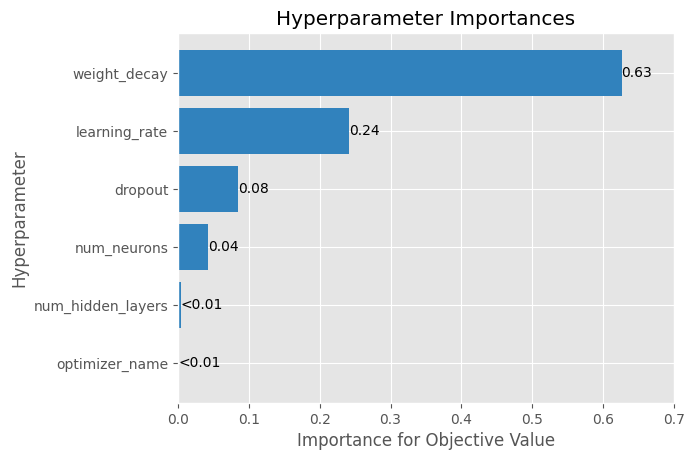

time: 322 ms (started: 2023-05-07 17:50:52 +00:00)


In [13]:
#shows the importance of each hyperparameter
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [14]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'SGD', 'weight_decay': 0.0011900571713779398, 'learning_rate': 0.0050072508426724826, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}
time: 709 µs (started: 2023-05-07 17:50:56 +00:00)


In [7]:
import os
import shutil

#this code combines both train and validation dataset into one training set, so we can use this to train the model on a larger dataset. 
train_dir = '/data/train'
val_dir = '/data/valid'

# Loop through the subdirectories in val_dir and move their files to train_dir
for class_dir in os.listdir(val_dir):
    src_class_dir = os.path.join(val_dir, class_dir)
    dst_class_dir = os.path.join(train_dir, class_dir)
        
    # Create the destination directory if it doesn't exist yet
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        
    # Loop through the files in the source directory and move them to the destination directory
    for file in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, file)
        dst_file = os.path.join(dst_class_dir, file)
        shutil.move(src_file, dst_file)

# Remove the val_dir if it is empty
if not os.listdir(val_dir):
    os.rmdir(val_dir)

time: 114 ms (started: 2023-05-08 13:56:17 +00:00)


In [ ]:
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)

In [ ]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

In [ ]:
#create the maxvit model
#to create this code, timm's library has been used. 
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head
num_hidden_layers = 2
num_neurons = 512
dropout = 0.5
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

In [21]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 241 ms (started: 2023-05-08 14:03:17 +00:00)


In [22]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(new_model.parameters(), lr=0.0050072508426724826, momentum=0.9, nesterov=True, weight_decay = 0.0011900571713779398)

time: 3.11 ms (started: 2023-05-08 14:03:17 +00:00)


In [23]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Initialize variables for early stopping
best_test_loss = float('inf')
no_improvement_count = 0
epochs = 20
num_epochs = 20

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the test set
    new_model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    y_true = []
    y_scores = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Calculate the test accuracy and test loss
    test_accuracy = 100 * correct / total
    test_loss /= len(test_dataloader.dataset)
  
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Epoch 1/20: Train Loss: 1.3271, Train Acc: 57.0297, Test Loss: 1.0764, Test Acc: 61.4735
Epoch 2/20: Train Loss: 0.9725, Train Acc: 65.5226, Test Loss: 0.9138, Test Acc: 67.4981
Epoch 3/20: Train Loss: 0.9234, Train Acc: 66.8823, Test Loss: 0.9100, Test Acc: 67.5365
Epoch 4/20: Train Loss: 0.8991, Train Acc: 67.4631, Test Loss: 0.8752, Test Acc: 68.2272
Epoch 5/20: Train Loss: 0.8842, Train Acc: 67.8680, Test Loss: 0.8802, Test Acc: 67.9969
Epoch 6/20: Train Loss: 0.8770, Train Acc: 67.8812, Test Loss: 0.8497, Test Acc: 69.3400
Epoch 7/20: Train Loss: 0.8679, Train Acc: 68.6293, Test Loss: 0.8583, Test Acc: 68.5725
Epoch 8/20: Train Loss: 0.8604, Train Acc: 68.9285, Test Loss: 0.8525, Test Acc: 68.8411
Epoch 9/20: Train Loss: 0.8643, Train Acc: 68.6689, Test Loss: 0.8482, Test Acc: 69.1865
Epoch 10/20: Train Loss: 0.8576, Train Acc: 68.8933, Test Loss: 0.8466, Test Acc: 69.5318
Epoch 11/20: Train Loss: 0.8465, Train Acc: 69.0473, Test Loss: 0.8585, Test Acc: 68.7260
Epoch 12/20: Train 

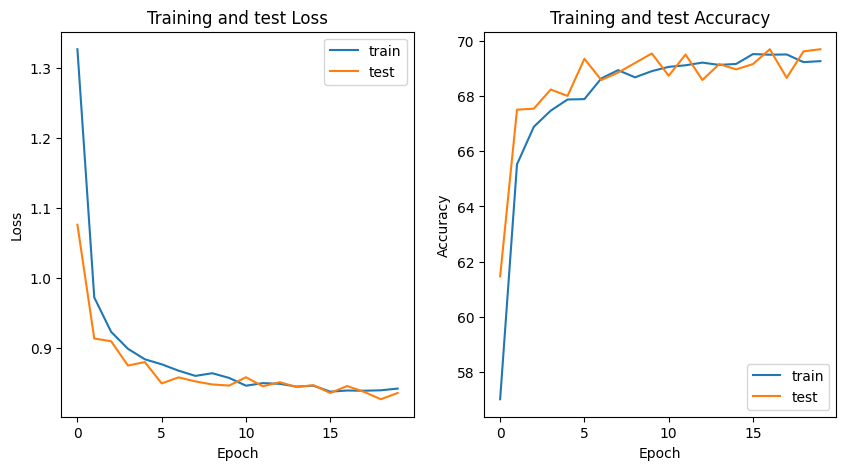

time: 258 ms (started: 2023-05-08 14:48:05 +00:00)


In [24]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [25]:
# Calculate other metrics and the final test accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy/100:.4f}") 
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.8360
Test Accuracy: 0.6969
Sensitivity: 0.6969
Specificity: 0.8379
ROC-AUC: 0.8742
F1-score: 0.4659
Classification Report:
              precision    recall  f1-score   support

           0     0.4000    0.2921    0.3377        89
           1     0.5771    0.7460    0.6508       311
           2     0.4697    0.4493    0.4593       276
           3     0.0000    0.0000    0.0000        27
           4     0.6782    0.4356    0.5304       450
           5     0.7823    0.8977    0.8360      1349
           6     0.6667    0.1951    0.3019        82
           7     0.7857    0.5000    0.6111        22

    accuracy                         0.6969      2606
   macro avg     0.5450    0.4395    0.4659      2606
weighted avg     0.6820    0.6969    0.6769      2606

time: 743 ms (started: 2023-05-08 14:48:05 +00:00)


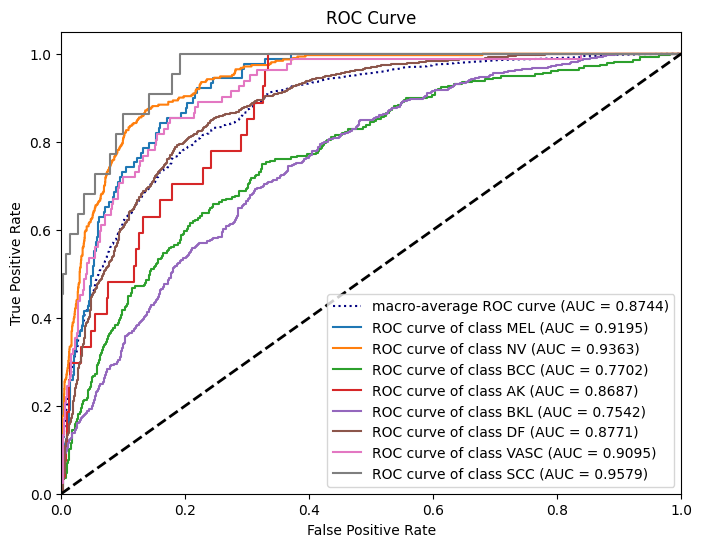

time: 193 ms (started: 2023-05-08 14:48:06 +00:00)


In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

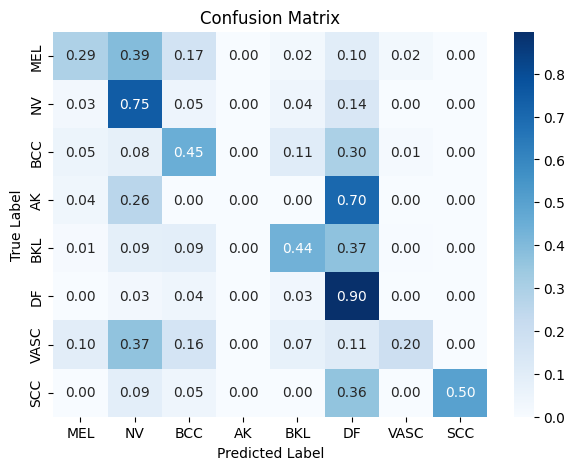

time: 275 ms (started: 2023-05-08 14:48:06 +00:00)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

